In [1]:
!pip install scikit-learn==1.3.2

In [2]:
!pip install lazypredict

In [3]:
import pandas as pd
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import RandomOverSampler

import lightgbm as lgb
from joblib import dump
import itertools
import matplotlib.pyplot as plt
import numpy as np
from lazypredict.Supervised import LazyClassifier
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import confusion_matrix, classification_report, roc_auc_score, accuracy_score, precision_score, recall_score, f1_score

/usr/local/lib/python3.10/dist-packages/dask/dataframe/__init__.py:42: FutureWarning: 
Dask dataframe query planning is disabled because dask-expr is not installed.

You can install it with `pip install dask[dataframe]` or `conda install dask`.
This will raise in a future version.

  warnings.warn(msg, FutureWarning)


In [4]:
rice_df = pd.read_excel('/content/rice_w2vec_4mer_dataset.xlsx')
rice_df = rice_df.drop(['circName','tissue','chr','start','end','strand','start_anno', 'circID',	'gene', 'isoform', 'width', 'detection_score', 'stress_detection_score', 'end_anno', 'antisense', 'algorithm', 'seq', 'exonSeq', 'predAA', 'miRNA','superCircRNARegion'], axis=1)

In [5]:
maize_df = pd.read_excel('maize_w2vec_4mer_dataset.xlsx')
maize_df = maize_df.drop(['circName','tissue','chr','start','end','strand','start_anno', 'circID',	'gene', 'isoform', 'width', 'detection_score', 'stress_detection_score', 'end_anno', 'antisense', 'algorithm', 'seq', 'exonSeq', 'predAA', 'miRNA','superCircRNARegion'], axis=1)

In [6]:
df = rice_df._append(maize_df, ignore_index = True)

In [7]:
df_drought = df.query('stress == "-" or stress == "drought"').replace('-', 0).replace('drought', 1)

### Training and Testing Models

In [8]:
# Define X and y (target) variables
X = df_drought.drop(['stress'], axis=1)
y = df_drought['stress']

In [9]:
X.head(2)

,wc_4mer_1,wc_4mer_2,wc_4mer_3,wc_4mer_4,wc_4mer_5,wc_4mer_6,wc_4mer_7,wc_4mer_8,wc_4mer_9,wc_4mer_10,...,wc_4mer_247,wc_4mer_248,wc_4mer_249,wc_4mer_250,wc_4mer_251,wc_4mer_252,wc_4mer_253,wc_4mer_254,wc_4mer_255,wc_4mer_256
0,-7.03,3.89,-3.41,19.99,-7.58,14.46,5.79,4.07,-18.32,-10.78,...,0.23,-13.99,4.97,-10.46,5.52,5.79,-4.05,16.67,11.18,-4.66
1,-11.00,-10.42,16.46,-88.31,1.41,-58.91,52.35,6.18,-41.47,-64.47,...,134.44,10.04,-8.81,46.56,-58.96,55.19,37.83,25.29,23.79,-36.15


In [10]:
y.value_counts()

,count
stress,
0,70996
1,12030


In [11]:
ros = RandomUnderSampler(sampling_strategy=0.55)

X_res, y_res = ros.fit_resample(X, y)

In [12]:
y_res.value_counts()

,count
stress,
0,21872
1,12030


In [13]:
X_train, X_test, y_train, y_test = train_test_split(X_res, y_res, test_size=0.20, random_state=106)

In [14]:
y_test.value_counts()

,count
stress,
0,4429
1,2352


In [15]:
rus = RandomUnderSampler(sampling_strategy=1)

X_test, y_test = rus.fit_resample(X_test, y_test)
y_test.value_counts()

,count
stress,
0,2352
1,2352


In [16]:
ros = RandomOverSampler(sampling_strategy=1)

X_train, y_train = ros.fit_resample(X_train, y_train)

In [17]:
y_train.value_counts()

,count
stress,
0,17443
1,17443


In [18]:
model_lgb = lgb.LGBMClassifier(random_state=106)
model_lgb.fit(X_train, y_train)

y_pred_lgb = model_lgb.predict(X_test)
report = classification_report(y_test, y_pred_lgb)
print(report)

[LightGBM] [Info] Number of positive: 17443, number of negative: 17443
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.127865 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 65280
[LightGBM] [Info] Number of data points in the train set: 34886, number of used features: 256
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
              precision    recall  f1-score   support

           0       0.89      0.71      0.79      2352
           1       0.76      0.91      0.83      2352

    accuracy                           0.81      4704
   macro avg       0.82      0.81      0.81      4704
weighted avg       0.82      0.81      0.81      4704



In [19]:
from sklearn.ensemble import RandomForestClassifier

modelrf = RandomForestClassifier(random_state=106)
modelrf.fit(X_train, y_train)

y_pred_rf = modelrf.predict(X_test)
report = classification_report(y_test, y_pred_rf)
print(report)

              precision    recall  f1-score   support

           0       0.85      0.73      0.78      2352
           1       0.76      0.87      0.81      2352

    accuracy                           0.80      4704
   macro avg       0.80      0.80      0.80      4704
weighted avg       0.80      0.80      0.80      4704



In [20]:
from sklearn.ensemble import ExtraTreesClassifier

modelext = ExtraTreesClassifier(random_state=106)
modelext.fit(X_train, y_train)

y_pred_ext = modelext.predict(X_test)
report = classification_report(y_test, y_pred_ext)
print(report)

              precision    recall  f1-score   support

           0       0.80      0.76      0.78      2352
           1       0.77      0.81      0.79      2352

    accuracy                           0.79      4704
   macro avg       0.79      0.79      0.78      4704
weighted avg       0.79      0.79      0.78      4704



In [21]:
from sklearn.dummy import DummyClassifier

dummy = DummyClassifier()
dummy.fit(X_train, y_train)

y_pred_dummy = dummy.predict(X_test)
report = classification_report(y_test, y_pred_dummy)
print(report)

              precision    recall  f1-score   support

           0       0.50      1.00      0.67      2352
           1       0.00      0.00      0.00      2352

    accuracy                           0.50      4704
   macro avg       0.25      0.50      0.33      4704
weighted avg       0.25      0.50      0.33      4704



In [22]:
dump(model_lgb, 'lgb_model_drought_4mer.joblib')
print('LGB - Cold Model created.')

LGB - Cold Model created.


In [23]:
dump(modelrf, 'rf_model_drought_4mer.joblib')
print('RF - Cold Model created.')

RF - Cold Model created.


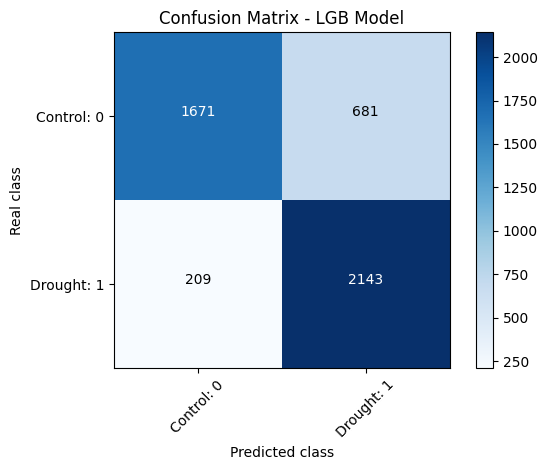

In [24]:
cnf_matrix = confusion_matrix(y_test, y_pred_lgb)

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion Matrix - LGB Model',
                          cmap=plt.cm.Blues):

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    #plt.ylim(0.5, 0.5)
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)
    plt.ylim(1.5, -0.5)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('Real class')
    plt.xlabel('Predicted class')
    plt.tight_layout()

plot_confusion_matrix(cnf_matrix, classes=['Control: 0', 'Drought: 1'])

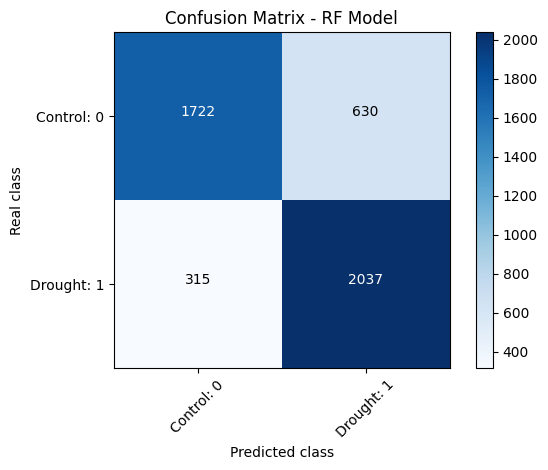

In [25]:
cnf_matrix = confusion_matrix(y_test, y_pred_rf)

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion Matrix - RF Model',
                          cmap=plt.cm.Blues):

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    #plt.ylim(0.5, 0.5)
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)
    plt.ylim(1.5, -0.5)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('Real class')
    plt.xlabel('Predicted class')
    plt.tight_layout()

plot_confusion_matrix(cnf_matrix, classes=['Control: 0', 'Drought: 1'])

In [26]:
from sklearn.model_selection import train_test_split, cross_val_score
scores = cross_val_score(model_lgb, X_res, y_res, cv=4)
print("Scores:", scores)
print("Median:", scores.mean())

[LightGBM] [Info] Number of positive: 9022, number of negative: 16404
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.155373 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 65280
[LightGBM] [Info] Number of data points in the train set: 25426, number of used features: 256
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.354834 -> initscore=-0.597859
[LightGBM] [Info] Start training from score -0.597859
[LightGBM] [Info] Number of positive: 9022, number of negative: 16404
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.090517 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 65280
[LightGBM] [Info] Number of data points in the train set: 25426, number of used features: 256
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.354834 -> initscore=-0.597859
[LightGBM] [Info] Start training from score -0.597859
[LightGBM]

In [27]:
from sklearn.model_selection import train_test_split, cross_val_score
scores = cross_val_score(modelrf, X_res, y_res, cv=4)
print("Scores:", scores)
print("Median:", scores.mean())

Scores: [0.71531383 0.78527607 0.80176991 0.73215339]
Median: 0.7586283011828645


In [28]:
import numpy as np
y_prob = model_lgb.predict_proba(X_test)[:, 1]

thresholds = np.arange(0.0, 1.1, 0.1)
results = []

for threshold in thresholds:
    y_pred_test = (y_prob >= threshold).astype(int)

    tn, fp, fn, tp = confusion_matrix(y_test, y_pred_test).ravel()
    precision = tp / (tp + fp) if (tp + fp) > 0 else 0
    recall = tp / (tp + fn) if (tp + fn) > 0 else 0
    f1 = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0
    auc = roc_auc_score(y_test, y_prob)
    accuracy = accuracy_score(y_test, y_pred_test)

    results.append({
        'Threshold': threshold,
        'Precision': precision,
        'Recall': recall,
        'F1 Score': f1,
        'AUC': auc,
        'Acurácia': accuracy
    })

results_df = pd.DataFrame(results)
print(results_df)

    Threshold  Precision  Recall  F1 Score  AUC  Acurácia
0        0.00       0.50    1.00      0.67 0.84      0.50
1        0.10       0.67    0.97      0.79 0.84      0.74
2        0.20       0.74    0.94      0.83 0.84      0.80
3        0.30       0.75    0.93      0.83 0.84      0.81
4        0.40       0.76    0.93      0.83 0.84      0.81
5        0.50       0.76    0.91      0.83 0.84      0.81
6        0.60       0.76    0.87      0.81 0.84      0.80
7        0.70       0.77    0.70      0.73 0.84      0.75
8        0.80       0.81    0.26      0.40 0.84      0.60
9        0.90       0.33    0.00      0.00 0.84      0.50
10       1.00       0.00    0.00      0.00 0.84      0.50


In [29]:
from sklearn.metrics import confusion_matrix, classification_report, roc_auc_score, accuracy_score
import numpy as np
y_prob = modelrf.predict_proba(X_test)[:, 1]

thresholds = np.arange(0.0, 1.1, 0.1)
results = []

for threshold in thresholds:
    y_pred_test = (y_prob >= threshold).astype(int)

    tn, fp, fn, tp = confusion_matrix(y_test, y_pred_test).ravel()
    precision = tp / (tp + fp) if (tp + fp) > 0 else 0
    recall = tp / (tp + fn) if (tp + fn) > 0 else 0
    f1 = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0
    auc = roc_auc_score(y_test, y_prob)
    accuracy = accuracy_score(y_test, y_pred_test)

    results.append({
        'Threshold': threshold,
        'Precision': precision,
        'Recall': recall,
        'F1 Score': f1,
        'AUC': auc,
        'Acurácia': accuracy
    })

results_df = pd.DataFrame(results)
print(results_df)

    Threshold  Precision  Recall  F1 Score  AUC  Acurácia
0        0.00       0.50    1.00      0.67 0.84      0.50
1        0.10       0.62    0.97      0.76 0.84      0.69
2        0.20       0.74    0.94      0.83 0.84      0.80
3        0.30       0.76    0.93      0.84 0.84      0.82
4        0.40       0.76    0.92      0.83 0.84      0.81
5        0.50       0.76    0.87      0.81 0.84      0.80
6        0.60       0.78    0.68      0.72 0.84      0.74
7        0.70       0.81    0.32      0.46 0.84      0.62
8        0.80       0.81    0.08      0.14 0.84      0.53
9        0.90       0.81    0.01      0.01 0.84      0.50
10       1.00       0.00    0.00      0.00 0.84      0.50
